<a href="https://colab.research.google.com/github/oluwamark/compx310/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1uAhlqOxfgg3T2awz0xRjfp1UaJcp7LLb?usp=sharing

### Task 1 - Preprocessing

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 1631625

# Note the seperator keyword here. ',' is the default; some csv files use tabs to separate fields. You would use sep='\t' to read such a file.
df=pd.read_csv("https://raw.githubusercontent.com/bpfa/data_for_compx310_2023/main/marketing_campaign.csv", sep=None, engine='python')

## The following code creates features that would be helpful to describe the profile of the customer
#  creates a new field to store the age of the customer,
#  recodes the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
#  recodes the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner)
#  creates a new field to store the number of children in the household
#  creates a new field to store the household size
df['Age']=2022-df['Year_Birth']
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True)
df['Children']=df['Kidhome']+df['Teenhome']
df['Family_Size']=df['Marital_Status']+df['Children']+1

## The following code creates features that would be helpful to describe the customer's purchasing preference and behaivior
#  creates a new field to store the total spending of the customer
#  creates subsequent fields to store the spending proportion for each product by the customer
df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df['Prop_Wines']=df["MntWines"]/df["Total_Spending"]
df['Prop_Fruits']=df["MntFruits"]/df["Total_Spending"]
df['Prop_MeatProducts']=df["MntMeatProducts"]/df["Total_Spending"]
df['Prop_FishProducts']=df["MntFishProducts"]/df["Total_Spending"]
df['Prop_SweetProducts']=df["MntSweetProducts"]/df["Total_Spending"]
df['Prop_GoldProds']=df["MntGoldProds"]/df["Total_Spending"]

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], dayfirst=True)
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

## The following code remove outliers in the dataset that are plausibly caused by data-entry errors (improbable values)
#  Generally, we would remove outliers when we do customer segmentation, as we are more interested in the general population rather than the outliers
df = df[(df["Age"]<90)]
df = df[(df["Income"]<110000)]
df = df[(df["NumWebVisitsMonth"]<11)]
df = df[(df["NumWebPurchases"]<20)]
df = df[(df["NumCatalogPurchases"]<20)]

## Finally we are going to drop some of the fields that are no longer relevant / unhelpful for the clustering
#  Note: depending on the question we would like to have answered, there is a case we can make to keep
#  'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts' and 'MntGoldProds', however
#  because we are interested in the purchasing preferance rather than amount spent, the field for the spending
#  proportion we created above would be more helpful
#  We dropped the responses to the individual promotions because very few customers react to those promotions
#  (not enough to form their own clusters), so instead we look at the overall response, using the field created above
#  Less than 1% of customers filed a complaint. We drop the field as it wouldn't create a meaningful cluster
fields_to_drop=['ID','Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue','AcceptedCmp1',
        'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain',
         'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
df.drop(fields_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)

## Helper function for to do 3d scatter plots,
def scatter_3d(x,y,z,c=None):
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='3d', label="bla")
    ax.scatter(x, y, z, s=40, c=c, marker='o',cmap=plt.cm.viridis)
    ax.set_title("The Plot Of The Clusters")
    plt.show()

/tmp/ipython-input-3805726993.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)
/tmp/ipython-input-3805726993.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Education"].replace({"Basic":0

###Task 2 - PCA

In [ ]:
# https://www.geeksforgeeks.org/machine-learning/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
# https://statisticallyrelevant.com/principal-component-analysis-in-python/
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
scaler = preprocessing.StandardScaler()

# scale data
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns = df.columns)

# PCA
pca = PCA(n_components=23)
fit_pca = pca.fit_transform(scaled_df)

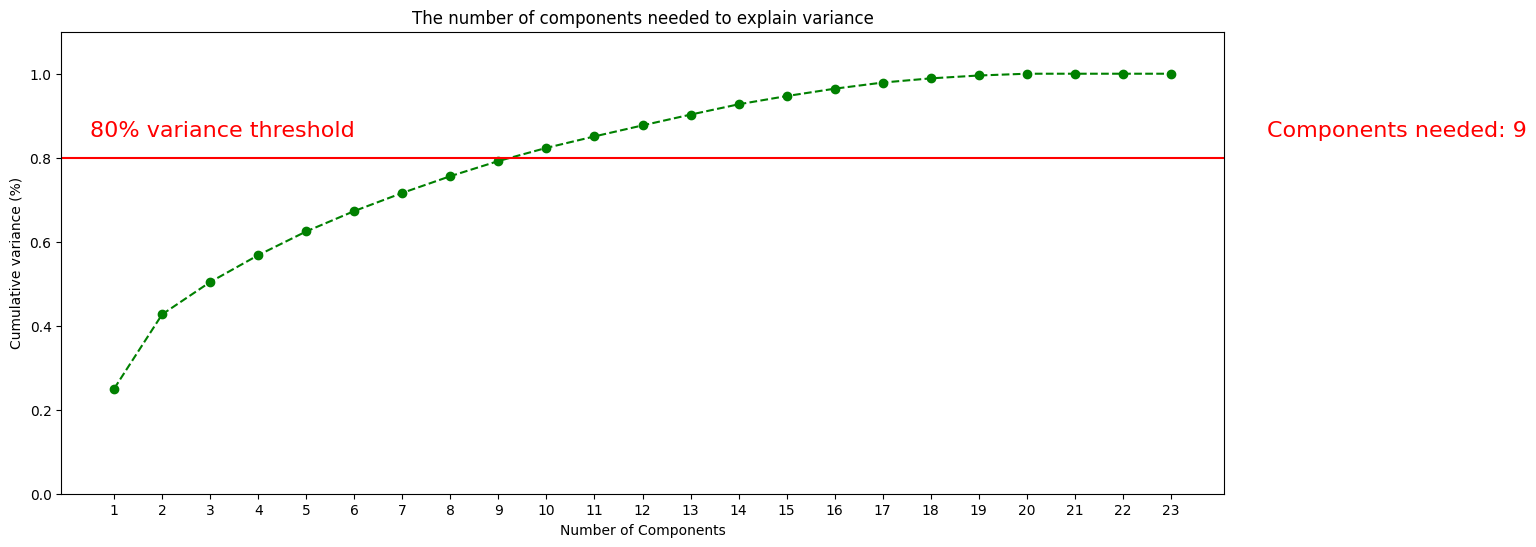

In [ ]:
# Fit PCA
pca = PCA(n_components=23)
fit_pca = pca.fit_transform(scaled_df)

# Plot the cumulative variance for each component
plt.figure(figsize = (15, 6))
components = np.arange(1, 24, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(components, variance, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 24, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% variance threshold', color = 'red', fontsize=16)
plt.text(25, 0.85, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0][0]), color = "red", fontsize=16)
plt.show()

/tmp/ipython-input-3805726993.py:70: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=40, c=c, marker='o',cmap=plt.cm.viridis)


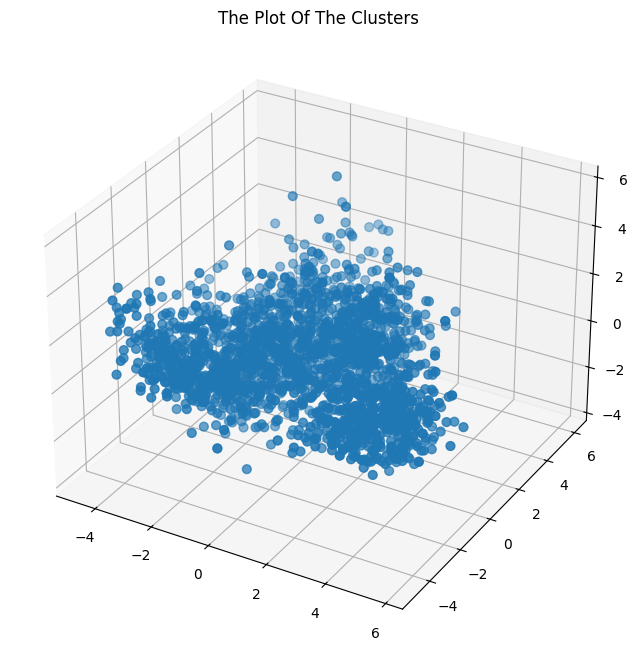

In [ ]:
# Redo PCA with 9 components
pca = PCA(n_components=9)
df_transformed = pca.fit_transform(scaled_df)
scatter_3d(df_transformed[:,0], df_transformed[:,1],df_transformed[:,2])

###Task 3 - KMeans Clustering

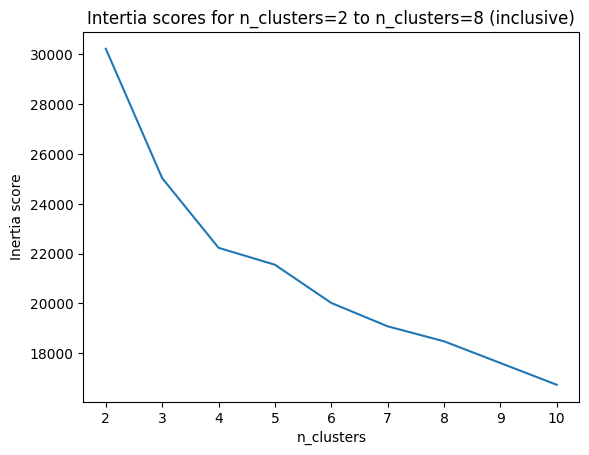

In [ ]:
# https://www.codecademy.com/learn/dspath-unsupervised/modules/dspath-clustering/cheatsheet

from sklearn.cluster import KMeans

# list for interita scores
inertia_scores = []

# (from hints)
for i in range (2,11,1):
  kmeans=KMeans(n_clusters=i, random_state=SEED)
  kmeans.fit(df_transformed)
  inertia_score=kmeans.inertia_
  inertia_scores.append(inertia_score)

x=range(2,11)
# plot inertia scores
plt.plot(x,inertia_scores)
plt.title("Intertia scores for n_clusters=2 to n_clusters=8 (inclusive)")
plt.xlabel("n_clusters")
plt.ylabel("Inertia score")
plt.show()

Inertia score specifies how well a dataset has been clustered by KMeans. Ideally, we'd want low clusters and inertia, however the above plot shows an inverse relationship (of some kind). The optimal number of clusters/inertia score is acheived at the 'elbow' of the inertia plot, which is the point where the rate of change of inertia begins to decrease (formally, the point in the graph where 'curvature' is maximised).

Examining the plot, the elbow appears to occur at n_clusters=4. So, the best number of clusters is 4.

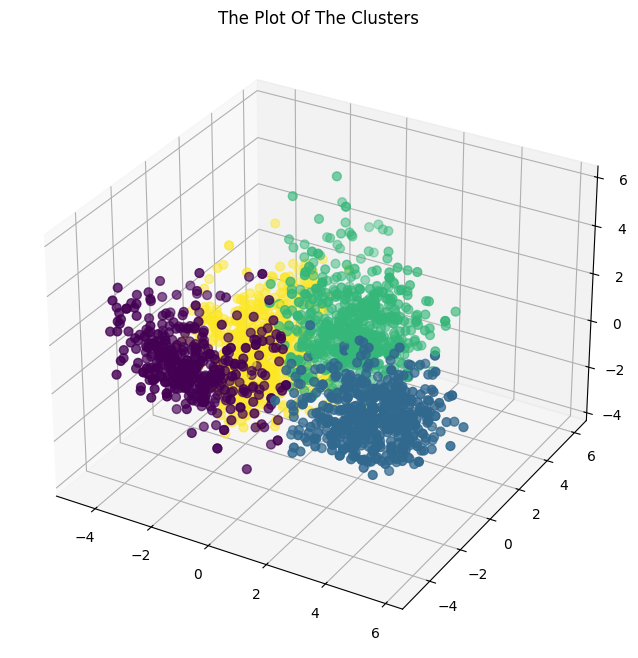

In [ ]:
# (from hints)
kmeans=KMeans(n_clusters=4, random_state=SEED)
kmeans.fit(df_transformed)

y_labels=kmeans.fit_predict(df_transformed)
df['Clusters'] = y_labels
scatter_3d(df_transformed[:,0], df_transformed[:,1],df_transformed[:,2], c=df['Clusters'])

###Task 4

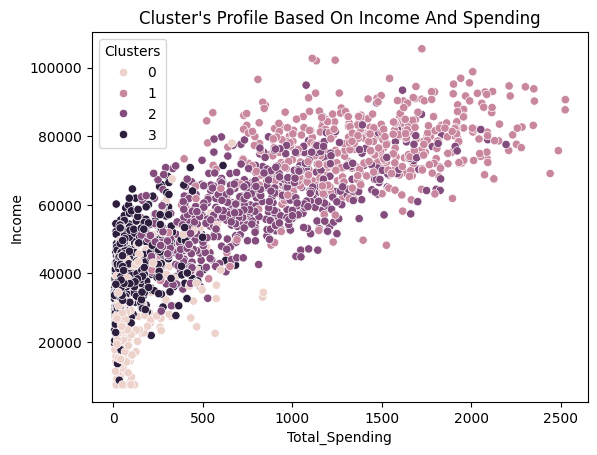

In [ ]:
import seaborn as sns

# scatter plot (from hints)
pl = sns.scatterplot(data=df, x="Total_Spending", y="Income",hue="Clusters")
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.show()

####Boxplots by customer attributes

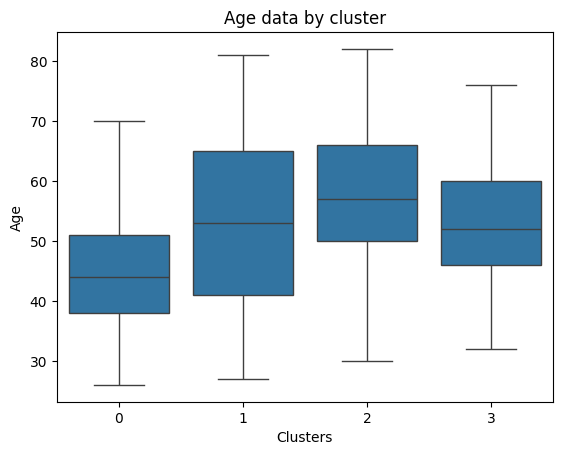

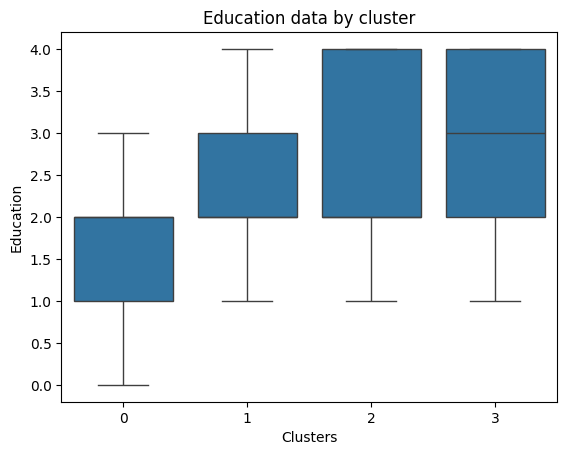

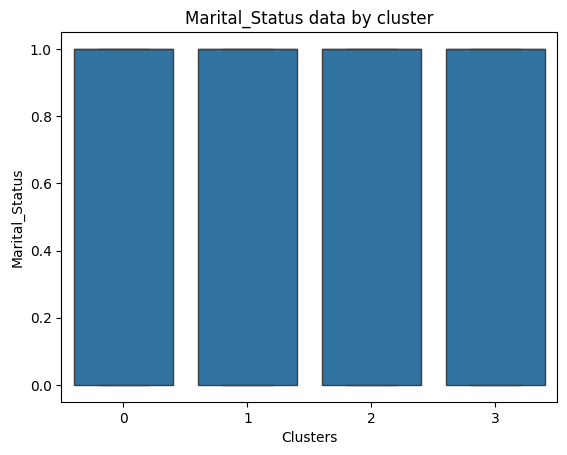

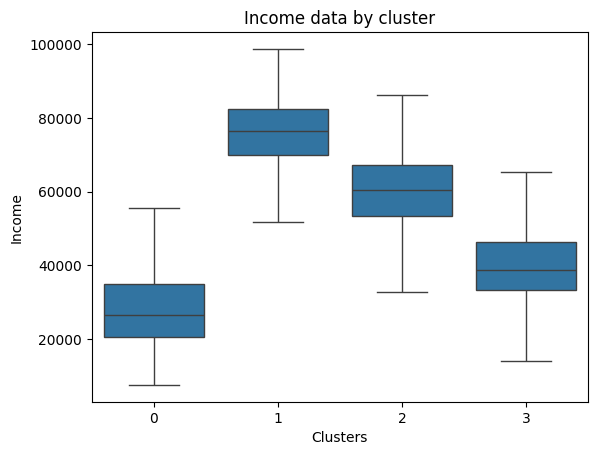

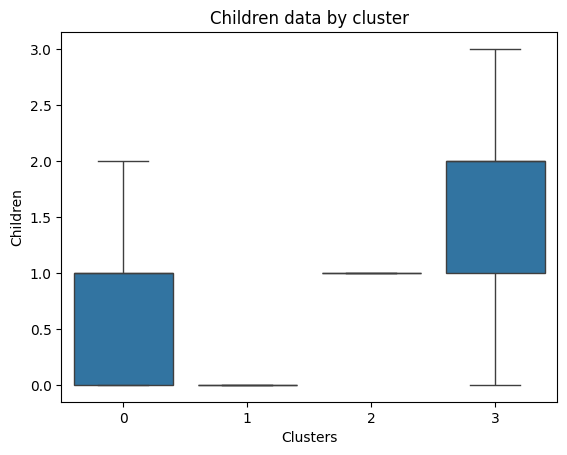

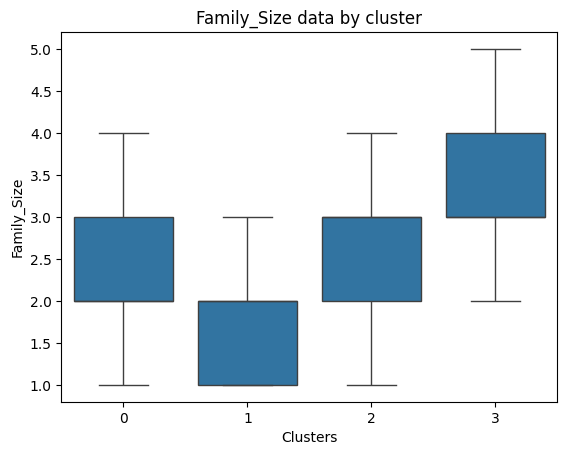

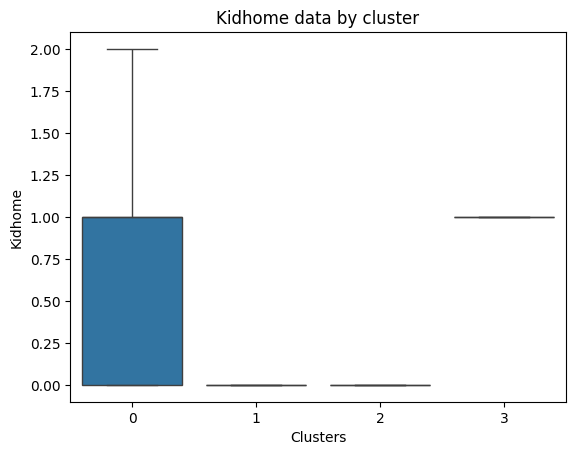

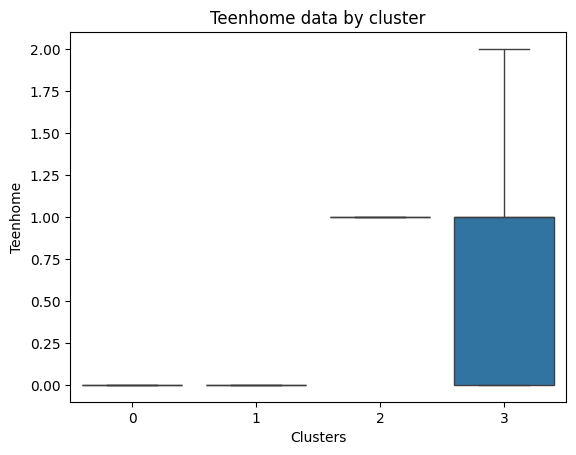

In [ ]:
import seaborn as sns

# fields describing to the customer
attribute_fields = ['Age','Education','Marital_Status','Income', 'Children', 'Family_Size','Kidhome','Teenhome']

# suppress outliers in boxplot
for field in attribute_fields:
  plt.figure()
  plt.title(f"{field} data by cluster")
  sns.boxplot(data=df, x='Clusters', y=field, showfliers=False)


####Boxplots by customer preference

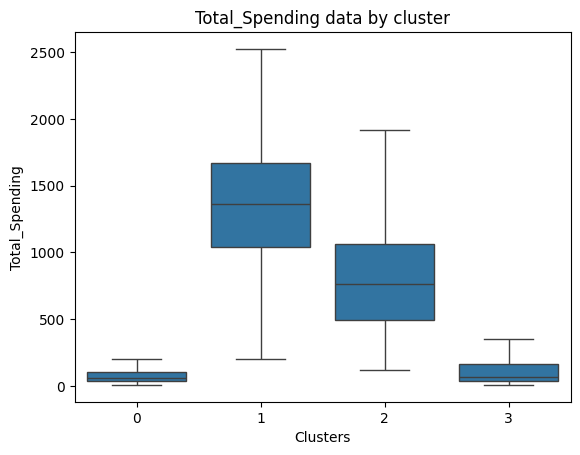

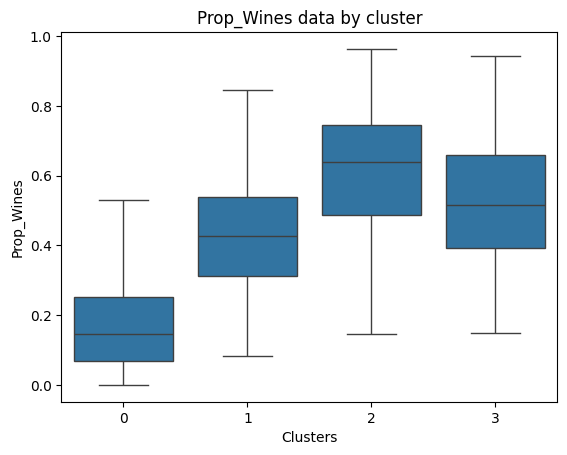

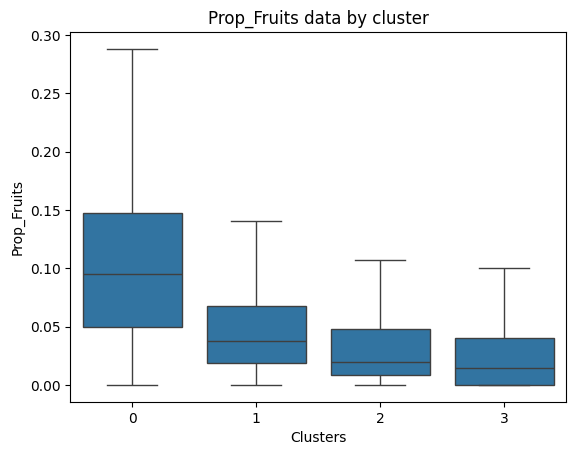

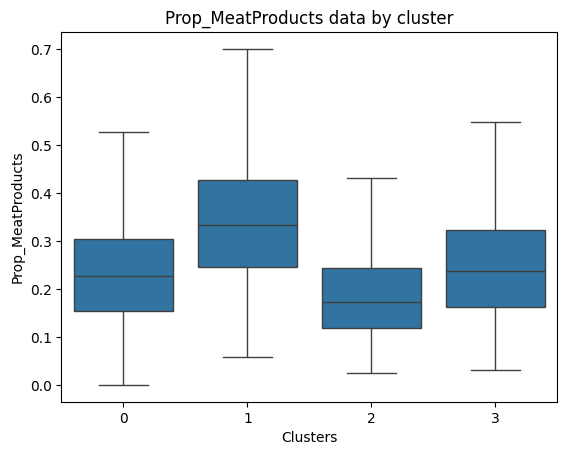

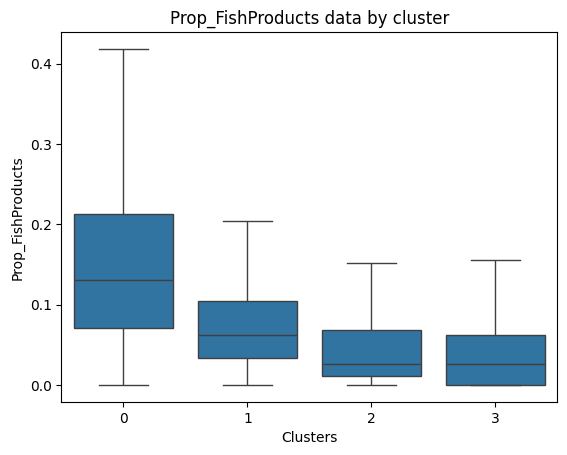

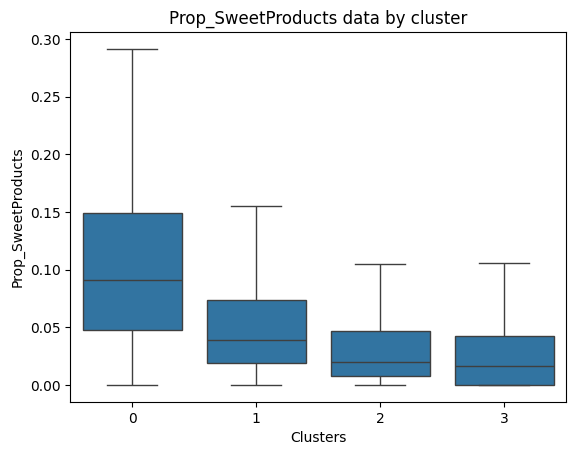

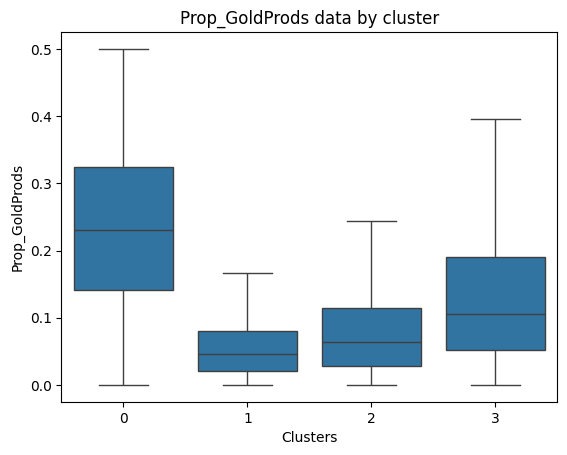

In [ ]:
# fields describing to the customer's shopping preferences
preference_fields =  ['Total_Spending','Prop_Wines','Prop_Fruits','Prop_MeatProducts','Prop_FishProducts','Prop_SweetProducts','Prop_GoldProds']

# suppress outliers in boxplot
for field in preference_fields:
  plt.figure()
  plt.title(f"{field} data by cluster")
  sns.boxplot(data=df, x='Clusters', y=field, showfliers=False)

####Box plots by customer behaviour

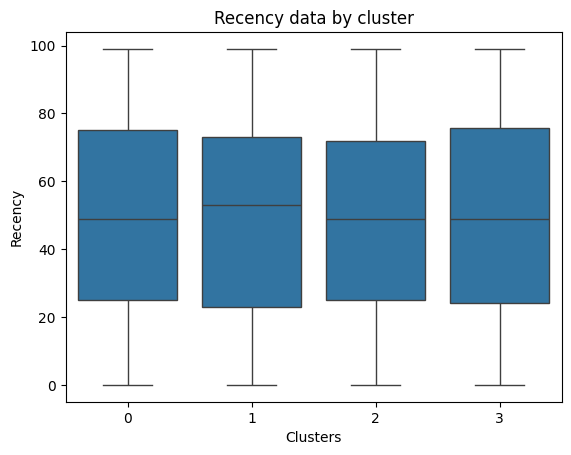

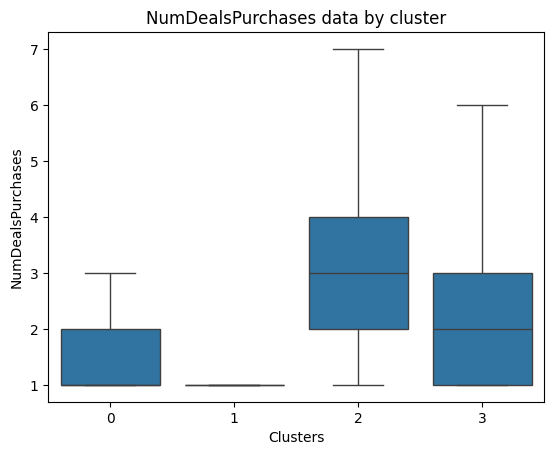

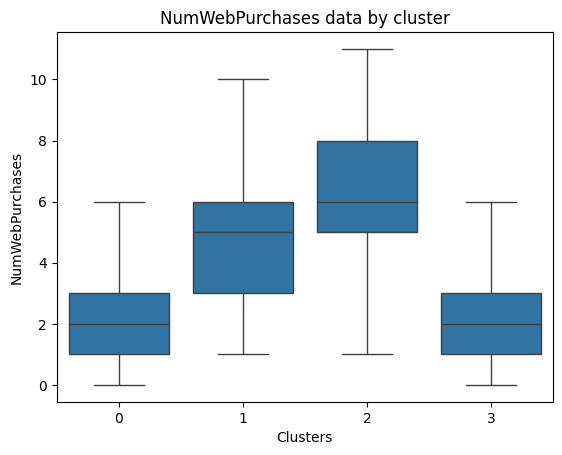

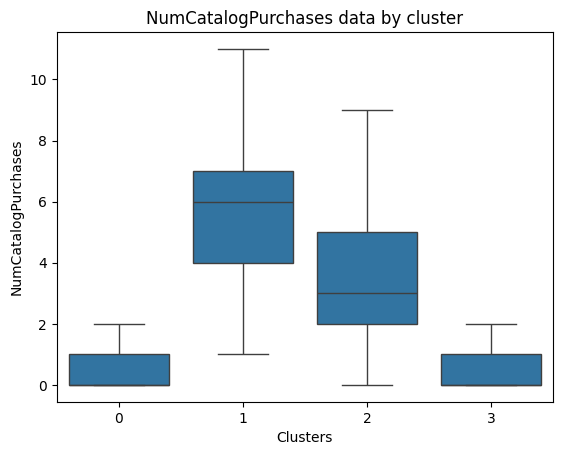

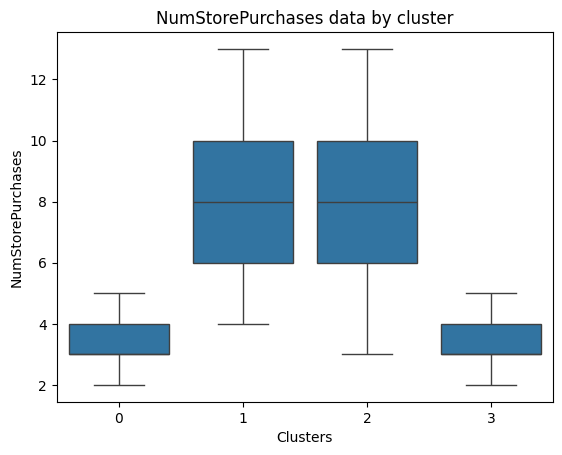

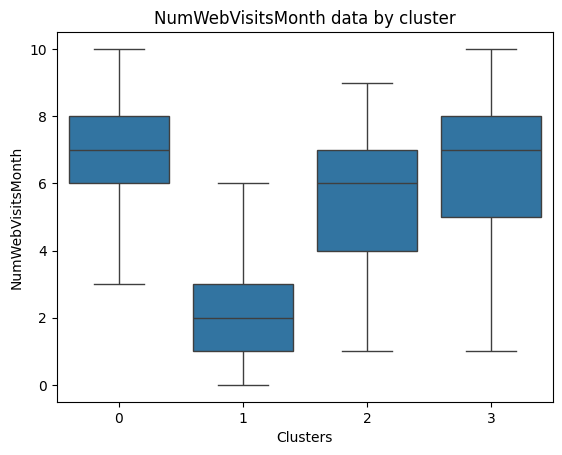

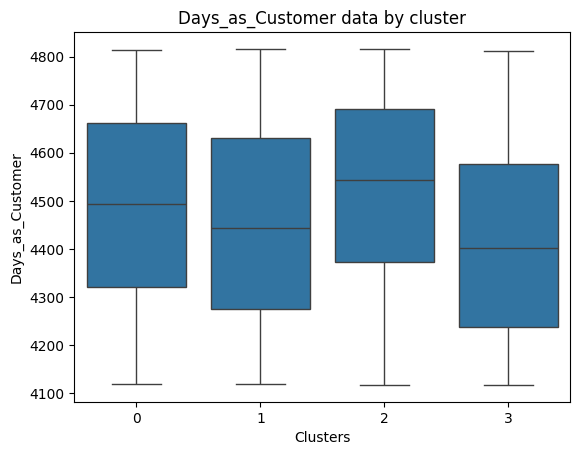

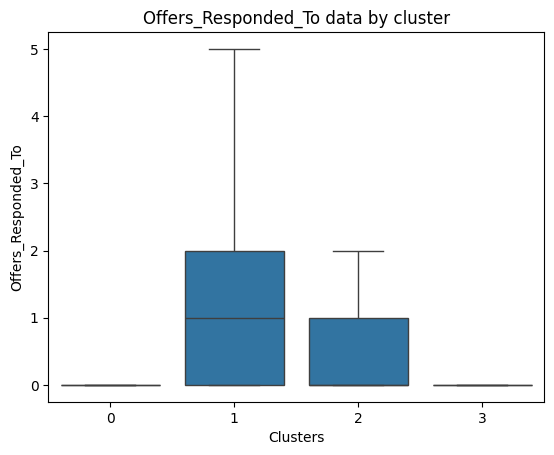

In [ ]:
# fields describing to the customer's shopping preferences
behaviour_fields =   ['Recency', 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Days_as_Customer', 'Offers_Responded_To']

# suppress outliers in boxplot
for field in behaviour_fields:
  plt.figure()
  plt.title(f"{field} data by cluster")
  sns.boxplot(data=df, x='Clusters', y=field, showfliers=False)

####Means grouped by cluster for each field

In [ ]:
# (from hints)
df.groupby('Clusters').mean().T

Clusters,0,1,2,3
Education,1.675991,2.505859,2.661927,2.744337
Marital_Status,0.620047,0.589844,0.674566,0.681230
Income,28362.268065,75814.316406,60271.139021,39670.711974
Kidhome,0.673660,0.023438,0.150079,0.930421
Teenhome,0.097902,0.042969,0.968404,0.700647
Recency,49.074592,49.328125,48.567141,49.320388
NumDealsPurchases,1.818182,1.046875,3.456556,2.503236
NumWebPurchases,2.172494,4.884766,6.369668,2.425566
NumCatalogPurchases,0.594406,5.896484,3.382306,0.627832
NumStorePurchases,3.293706,8.283203,8.004739,3.425566


###Observations

* The low-income customers - Clusters 0 and 3 - visit the web store more frequently than the higher-income customers (Clusters 1 and 2. Customers in Clusters 1 and 2 had over three times the number of monthly web visit than those in the highest income group (cluster 2). Despite more visits, the higher-income groups had more online purchases.


* The higher-income groups were much more likely to purchase from the catalogue in comparison to the low income groups: Low-income customers made, on average, less than one catalog purchase per month.

* The order of mean total spending for the clusters follows the order of income, meaning the highest income group spends the most while the lowest income group (Cluster 0) spends the least. However, the ammount spent is not in proportion to income. Cluster 2 spent approximately 13 times more than Cluster 0 despite the mean yearly income being only 3 times greater than Cluster 0.

* The highest income group was the most likely group to purchase meat products.

* The two low-income groups were the most likely to purchase gold products, with Cluster 0 being the most likely of all four clusters.

* There is no discernable relationship between alchohol purchasing and household income, however larger families tended to purchase more alchohol in this dataset.

###Convert to pdf

In [ ]:
!sudo apt-get update
!sudo apt-get install pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic -y
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Lab9-MatthewChristensen-1631625.ipynb"

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,065 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,